In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
from math import pi
from pathlib import Path

from functorch import vmap
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

from caustic.cosmology import FlatLambdaCDM, h0_default
from caustic.lenses.alphagen import (
    JointModel_ST_CNN,
    Normalizer,
    SIE,
    Point,
    get_pix_magnification,
    get_pix_jacobian,
    get_magnification,
)
from caustic.parametrized import Parametrized
from caustic.sources import Sersic
from caustic.utils import get_meshgrid

In [33]:
def load_model(kind: str, npix: int = 128, base_path: Path = Path("alphagen-weights")):
    base_path = base_path / f"{kind}_weights"

    with open(base_path / f"{kind}_hp.json", "r") as f:
        hps = json.load(f)

    normalizer = Normalizer(
        hps["normalize"], "NFW", hps["segment"], base_path / f"{kind}_stats.h5"
    )

    model = JointModel_ST_CNN(
        **hps["set_model"], **hps["map_model"], npix=npix, normalizer=normalizer
    )
    return model

In [38]:
f_state_path = Path("alphagen-weights") / "f_weights" / "AlphaGen_F_prodruns_4_2500.pt"
f_net = load_model("f")
f_net.load_state_dict(torch.load(f_state_path, map_location="cpu")["model_state_dict"])

b_state_path = Path("alphagen-weights") / "b_weights" / "AlphaGen_B_prodruns_1_1000.pt"
b_net = load_model("b")
b_net.load_state_dict(torch.load(b_state_path, map_location="cpu")["model_state_dict"])

<All keys matched successfully>

In [3]:
class Simulator(Parametrized):
    def __init__(
        self,
        res,
        n_pix,
        lens,
        src,
        f_net: JointModel_ST_CNN,
        b_net: JointModel_ST_CNN,
        z_s=None,
        upsample_factor=4,
        name: str = "sim",
    ):
        super().__init__(name)
        self.f_net = f_net
        self.lens = lens
        self.b_net = b_net
        self.src = src
        self.add_param("z_s", z_s)
        self.thx, self.thy = get_meshgrid(res, n_pix, n_pix)

    def __call__(self, x):
        x = self.x_to_dict(x)

        z_s = self.unpack(x)

        # TODO: batch and normalize halo parameters
        h_f = ...
        h_b = ...

        # Ray-trace up to main deflector
        f_coords = torch.stack((self.thx, self.thy))
        f_coords = self.f_net.normalizer.forward_x(f_coords)
        f_coords = torch.cat((f_coords, z_s.repeat(1, self.n_pix, self.n_pix)))
        h_f = self.f_net.normalizer.forward(h_f)
        alpha_f = self.f_net(h_f, f_coords)
        alpha_f = self.f_net.normalizer.reverse_alpha(alpha_f[0], -1)  # TODO: batch
        bx_md = self.thx - alpha_f[0]
        by_md = self.thy - alpha_f[1]

        # Get physical deflection angle for main deflector
        ax_hat, ay_hat = self.lens.alpha_hat(bx_md, by_md, z_s, x)

        # Ray-trace to source
        h_b, alphas, betas, _ = self.b_net.normalizer.forward(
            h_b, torch.stack((ax_hat, ay_hat)), torch.stack((bx_md, by_md))
        )
        b_coords = torch.cat((alphas, betas, z_s.repeat(1, self.n_pix, self.n_pix)))
        alpha_b = self.b_net(h_b, b_coords)
        alpha_b = self.b_net.normalizer.reverse_alpha(alpha_b[0], -1)  # TODO: batch
        bx = self.thx - alpha_b[0]
        by = self.thx - alpha_b[1]

        return self.src.brightness(bx, by, x)

In [ ]:
# f_net shapes
# h: (b, n_halos, n_params)
# x: (b, 3, n_pix, n_pix), where 3 is for (thx, thy, z)
# Output: ax, ay

# b_net shapes
# h: (b, n_halos, n_params)
# x: (b, 5, n_pix, n_pix), where 5 is for (thx, thy, ax_hat, ay_hat, z)
# Output: ax, ay

caught exception:  "cannot add FlatLambdaCDM(name='cosmo', static=[rho_cr_0, Om0], dynamic=[h0], x keys=[('cosmo': ['h0'])]): a component with the name 'cosmo' already exists in the model DAG" 

Simulator(
    name='sim',
    static=[z_s],
    dynamic=[],
    x keys=[('sie': ['z_l']), ('cosmo': ['h0']), ('src': ['thx0', 'thy0'])]
) 

SIE(
    name='sie',
    static=[thx0, thy0, q, phi, b],
    dynamic=[z_l],
    x keys=[('sie': ['z_l']), ('cosmo': ['h0'])]
) 

FlatLambdaCDM(
    name='cosmo',
    static=[rho_cr_0, Om0],
    dynamic=[h0],
    x keys=[('cosmo': ['h0'])]
) 

Sersic(
    name='src',
    static=[q, phi, index, th_e, I_e],
    dynamic=[thx0, thy0],
    x keys=[('src': ['thx0', 'thy0'])]
) 

testing x size error checking:
caught exception:  0 flattened dynamic args were passed, but 4 are required 

running with valid argument vector

vmap shape check: torch.Size([10, 50, 50])


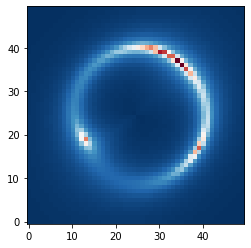

In [4]:
# Set up cosmology, marking H0 as dynamic
cosmo = FlatLambdaCDM("cosmo", h0=None)

# Static SIE args: z_l, thx0, thy0, q, phi, b
x_lens = torch.tensor([0.0, 0.0, 0.8, pi / 6, 1.5])
try:
    sie = SIE("cosmo", cosmo, None, *x_lens)
except KeyError as e:
    print("caught exception: ", e, "\n")

sie = SIE("sie", cosmo, None, *x_lens)

# Static Sersic args: q, phi, index, th_e, I_e
x_src = torch.tensor([0.6, pi / 4, 4.0, 2.5, 1.0])
src = Sersic("src", None, None, *x_src)

sim = Simulator(0.1, 50, sie, src, torch.tensor(0.8))
print(sim, "\n")
print(sie, "\n")
print(cosmo, "\n")
print(src, "\n")

print("testing x size error checking:")
x = torch.tensor([])
try:
    sim.x_to_dict(x)
except ValueError as e:
    print("caught exception: ", e, "\n")

print("running with valid argument vector")
x = torch.tensor([0.8, 0.7, 0.13, 0.04])
plt.imshow(sim(x), origin="lower", cmap="RdBu_r")
print()

print("vmap shape check:", vmap(sim)(x.repeat(10, 1)).shape)

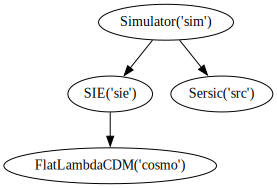

In [19]:
sim.get_graph()

In [ ]:
sim.get_graph(True, True).render("/Users/amcoogan/Downloads/sim-weird")

In [ ]:
fov = 5.0
n_pix = 1_000
thx, thy = get_meshgrid(fov / n_pix, n_pix, n_pix)
z_s = torch.tensor(2.1)
x = torch.tensor([0.8, 0.7])

In [ ]:
sie.magnification(thx, thy, z_s, sie.x_to_dict(x))

There are a few things I'm not clear on with this approach.
- In this approach, I don't think we can't run the same model component on different parameters: through the component's name, it's tied to one set of parameters in `x`. This makes it expensive to do things like include multiple `KappaGrid` lenses: each set of `Param`s must be associated with one `KappaGrid`, so we need to create a redundant set of kernels.
- How should we handle `Param`s like `z_s`? In what's above, I made this a parameter of the simulator, but that means we have to explicitly pass it to `raytrace`. How will this generalize?
- Is it confusing that names of `Param`s and `Parametrized` don't match the names of the attributes they're bound to?